In [ ]:
import cv2
import math
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

# %matplotlib inline

In [ ]:
data_dir = Path('/sda1/Datasets/VOC2012')
image_paths = sorted(Path(data_dir / 'Object/images').glob('*.png'))
mask_paths = sorted(Path(data_dir / 'Object/masks').glob('*.png'))
print(len(image_paths), len(mask_paths))

## Utils

In [ ]:
def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = math.atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = math.sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * math.cos(angle)
    q[1] = p[1] - scale * hypotenuse * math.sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    # p[0] = q[0] + 9 * math.cos(angle + math.pi / 4)
    # p[1] = q[1] + 9 * math.sin(angle + math.pi / 4)
    # cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # p[0] = q[0] + 9 * math.cos(angle - math.pi / 4)
    # p[1] = q[1] + 9 * math.sin(angle - math.pi / 4)
    # cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

In [ ]:
def rotate_img(img, angle):
    """中心旋转图像,输入的angle为弧度制"""
    angle_o=(angle-math.pi/2)*180/math.pi #将弧度制转为角度制
    height = img.shape[0]  # 原始图像高度
    width = img.shape[1]  # 原始图像宽度
    rotateMat = cv2.getRotationMatrix2D((width / 2, height / 2), angle_o, 1)  # 按angle角度旋转图像
    heightNew = int(width * math.fabs(math.sin(angle)) + height * math.fabs(math.cos(angle)))
    widthNew = int(height * math.fabs(math.sin(angle)) + width * math.fabs(math.cos(angle)))

    rotateMat[0, 2] += (widthNew - width) / 2
    rotateMat[1, 2] += (heightNew - height) / 2
    imgRotation = cv2.warpAffine(img, rotateMat, (widthNew, heightNew), borderValue=(0, 0, 0))
    return imgRotation

In [ ]:
def pca_angle(mask):

    _, bw = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    object_index = contours[0].squeeze()

    mean, eigen_vectors, eigen_values = cv2.PCACompute2(object_index.astype(float), np.zeros(0))
    # Store the center of the object
    # cntr = (int(mean[0,0]), int(mean[0,1]))
    # draw_mask = mask.copy()[..., None].repeat(3, axis=2)
    # cv2.circle(draw_mask, cntr, 3, (255, 0, 255), 2)

    # p1 = (cntr[0] + 0.02 * eigen_vectors[0,0] * eigen_values[0,0], cntr[1] + 0.02 * eigen_vectors[0,1] * # eigen_values[0,0])
    # p2 = (cntr[0] - 0.02 * eigen_vectors[1,0] * eigen_values[1,0], cntr[1] - 0.02 * eigen_vectors[1,1] * eigen_values[1,0])

    # draw_axis(draw_mask, cntr, p1, (0, 255, 0), 1)
    # draw_axis(draw_mask, cntr, p2, (255, 255, 0), 1)
    # display(Image.fromarray(draw_mask))

    angle = math.atan2(eigen_vectors[0,1], eigen_vectors[0,0]) # orientation in radians
    return angle

In [51]:
img = np.array(Image.open(image_paths[0]).convert('RGB'))
mask = np.array(Image.open(mask_paths[0]).convert('L'))
print(f'{image_paths[0]}: {img.shape}')

/sda1/Datasets/VOC2012/Object/images/2007_000033_1.png: (256, 256, 3)


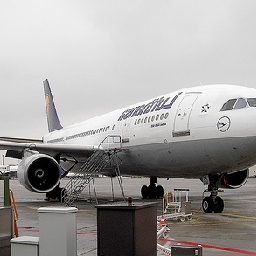

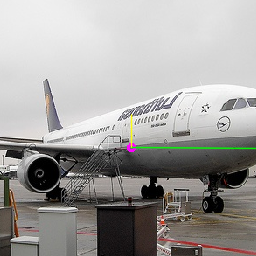

In [52]:
# PCA to get the principal axis
_, bw = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
object_index = contours[0].squeeze()

mean, eigen_vectors, eigen_values = cv2.PCACompute2(object_index.astype(float), np.zeros(0))

# Store the center of the object
cntr = (int(mean[0,0]), int(mean[0,1]))
draw_img = img.copy()
cv2.circle(draw_img, cntr, 3, (255, 0, 255), 2)

p1 = (cntr[0] + 0.02 * eigen_vectors[0,0] * eigen_values[0,0], cntr[1] + 0.02 * eigen_vectors[0,1] * eigen_values[0,0])
p2 = (cntr[0] - 0.02 * eigen_vectors[1,0] * eigen_values[1,0], cntr[1] - 0.02 * eigen_vectors[1,1] * eigen_values[1,0])

draw_axis(draw_img, cntr, p1, (0, 255, 0), 1)
draw_axis(draw_img, cntr, p2, (255, 255, 0), 1)

display(Image.fromarray(img))
display(Image.fromarray(draw_img))

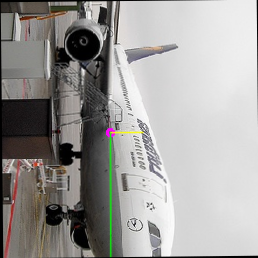

In [48]:
angle = math.atan2(eigen_vectors[0,1], eigen_vectors[0,0]) # orientation in radians
display(Image.fromarray(rotate_img(draw_img, angle)))

In [ ]:
content_mask = np.ones_like(img, dtype=np.uint8) * 255
plt.imshow(Image.fromarray(content_mask))

(503, 611, 3)


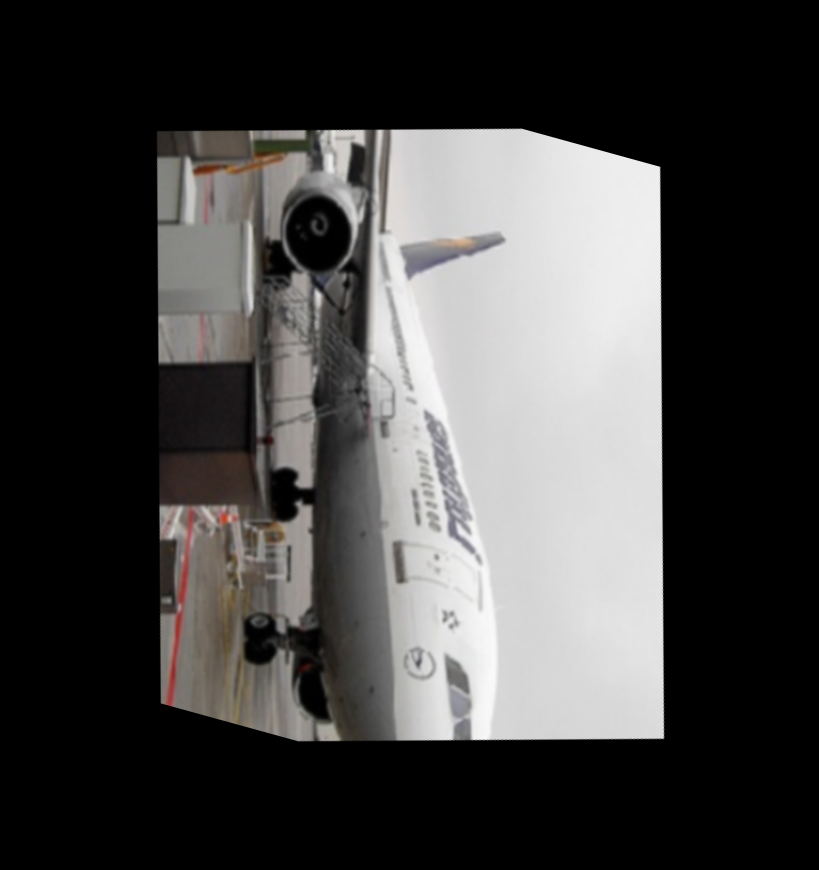

(466, 594, 3)


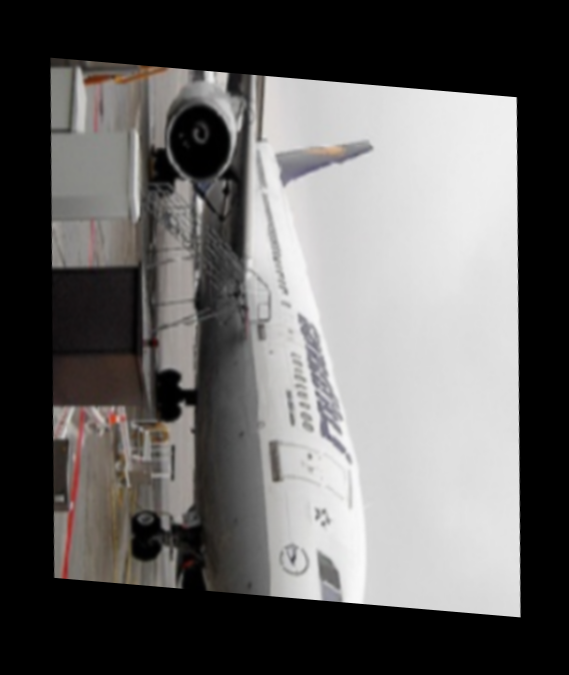

(589, 594, 3)


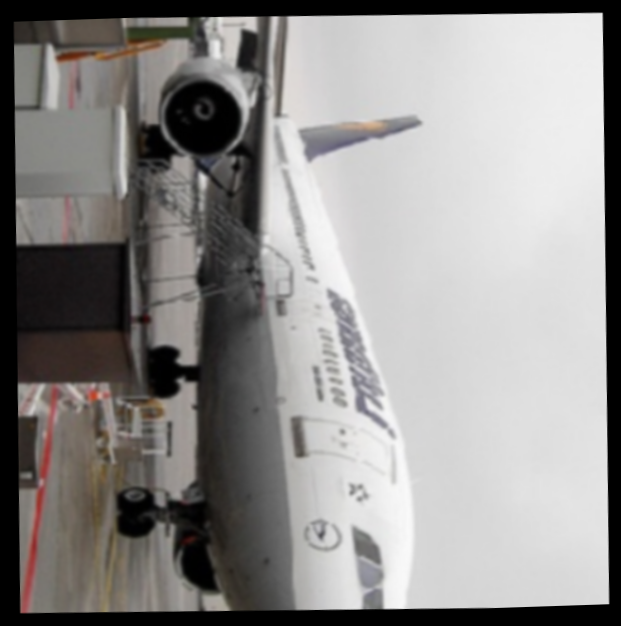

In [47]:
for _ in range(3):
    img = cv2.resize(img, None, fx=0.9 + 0.4 * np.random.rand(), fy=0.9 + 0.4 * np.random.rand())
    print(img.shape)
    content_mask = np.ones_like(img, dtype=np.uint8) * 255
    angle = np.random.uniform(-math.pi/2, math.pi/2)
    rot_img = rotate_img(img, angle)
    rot_mask = rotate_img(mask, angle)
    rot_content_mask = rotate_img(content_mask, angle)
    # display(Image.fromarray(rot_img))
    # display(Image.fromarray(rot_mask))
    angle = pca_angle(rot_mask)
    rot_bk_img = rotate_img(rot_img, angle)
    rot_content_mask = rotate_img(rot_content_mask, angle)
    display(Image.fromarray(rot_bk_img))
    # display(Image.fromarray(rot_content_mask))

    # Remove additional padding
    content_mask = rot_bk_img